In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import scipy 
import tqdm
import maxent
import os
tf.random.set_seed(0)
np.random.seed(0)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sns.set_context('paper')
sns.set_style('whitegrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
#plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
%matplotlib inline

## Set-up Prior Distribution

In [2]:
x = np.array([1., 1.])
i = tf.keras.Input((1,))
l = maxent.TrainableInputLayer(x)(i)
d = tfp.layers.DistributionLambda(lambda x: tfd.Normal(loc=x[...,0], scale=tf.math.exp(x[...,1])))(l)
model = maxent.ParameterJoint([lambda x: x], inputs=i, outputs=[d])
model.compile(tf.keras.optimizers.Adam(0.1))
model.summary()
model(tf.constant([1.]))

Model: "parameter_joint"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
trainable_input_layer (Train (None, 2)                 2         
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


<tfp.distributions.Normal 'parameter_joint_distribution_lambda_Normal' batch_shape=[1] event_shape=[] dtype=float32>

## Simulator

In [3]:
def simulate(x):
    y = np.random.normal(loc=x, scale=0.1)
    return y
plt.figure()
unbiased_params = model.sample(100000)
y = simulate(*unbiased_params)
y = np.squeeze(y)

<Figure size 432x288 with 0 Axes>

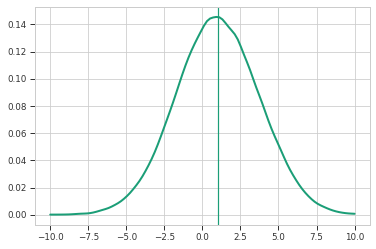

In [4]:
pdf = scipy.stats.gaussian_kde(y)
x = np.linspace(-10, 10, 100)
plt.plot(x, pdf.pdf(x), color=colors[0], linewidth=2)
plt.axvline(np.mean(y), color=colors[0])

## Maximum Entropy Method

In [5]:
r = maxent.Restraint(lambda x: x, 4, maxent.EmptyPrior())

me_model = maxent.MaxentModel([r])
me_model.compile(tf.keras.optimizers.Adam(0.01), 'mean_squared_error')
result = me_model.fit(y, epochs=4, batch_size=128)

Epoch 1/4
782/782 [==============================] - 1s 403us/step - loss: 0.5423 - weight-entropy: 4.3182
Epoch 2/4
782/782 [==============================] - 0s 395us/step - loss: 0.3973 - weight-entropy: 4.3010
Epoch 3/4
782/782 [==============================] - 0s 417us/step - loss: 0.3923 - weight-entropy: 4.2992
Epoch 4/4
782/782 [==============================] - 0s 411us/step - loss: 0.4238 - weight-entropy: 4.3039


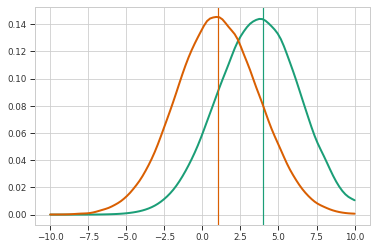

In [6]:
plt.axvline(x=4, color=colors[0])
wpdf = scipy.stats.gaussian_kde(np.squeeze(y), weights=np.squeeze(me_model.traj_weights))
x = np.linspace(-10, 10, 100)
plt.plot(x, wpdf.pdf(x), color=colors[0], linewidth=2)


plt.plot(x, pdf.pdf(x), color=colors[1], linewidth=2)
plt.axvline(np.mean(np.squeeze(y)), color=colors[1])

## Variational MaxEnt

Try to fit to more extreme value - 10

In [7]:
r = maxent.Restraint(lambda x: x, 10, maxent.EmptyPrior())
hme_model = maxent.HyperMaxentModel([r], model, simulate)
hme_model.compile(tf.keras.optimizers.SGD(0.005), 'mean_squared_error')
result = hme_model.fit(epochs=4, sample_batch_size=len(y) // 4, verbose=0)


In [8]:
w2pdf = scipy.stats.gaussian_kde(np.squeeze(hme_model.trajs), weights=np.squeeze(hme_model.traj_weights))

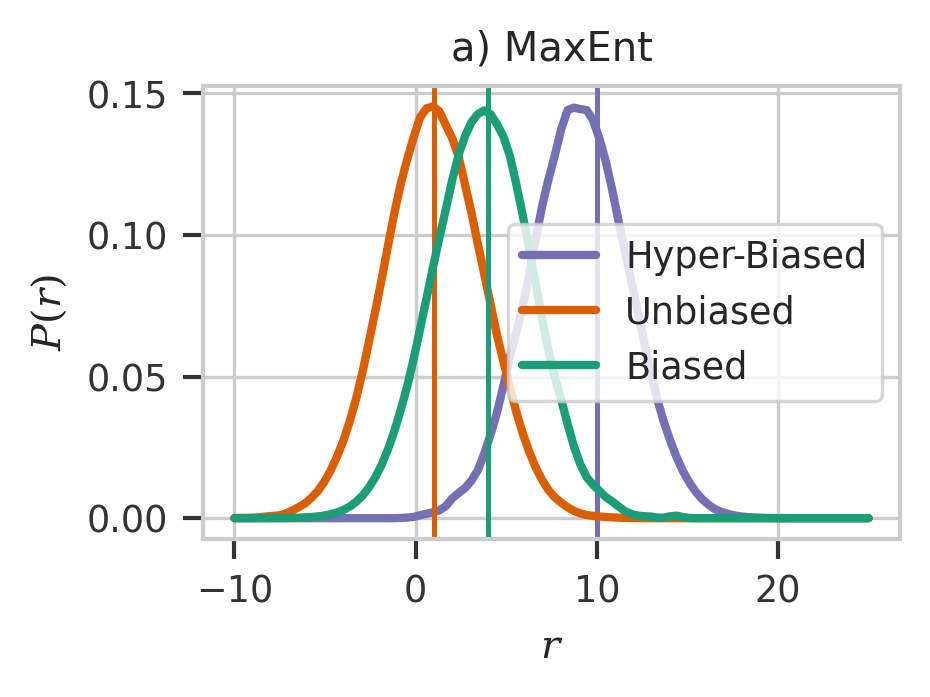

In [9]:
plt.figure(figsize=(3,2), dpi=300)
x = np.linspace(-10, 25, 100)
plt.plot(x, w2pdf.pdf(x), color=colors[2], linewidth=2, label='Hyper-Biased')
plt.axvline(x=10, color=colors[2])

plt.plot(x, pdf.pdf(x), color=colors[1], linewidth=2, label='Unbiased')
plt.axvline(np.mean(np.squeeze(y)), color=colors[1])

plt.plot(x, wpdf.pdf(x), color=colors[0], linewidth=2, label='Biased')
plt.axvline(x=4, color=colors[0])
plt.xlabel(r'$r$')
plt.ylabel(r'$P(r)$')
plt.title('a) MaxEnt')
plt.legend()
plt.savefig('maxent.svg')


## Bayesian Inference Setting

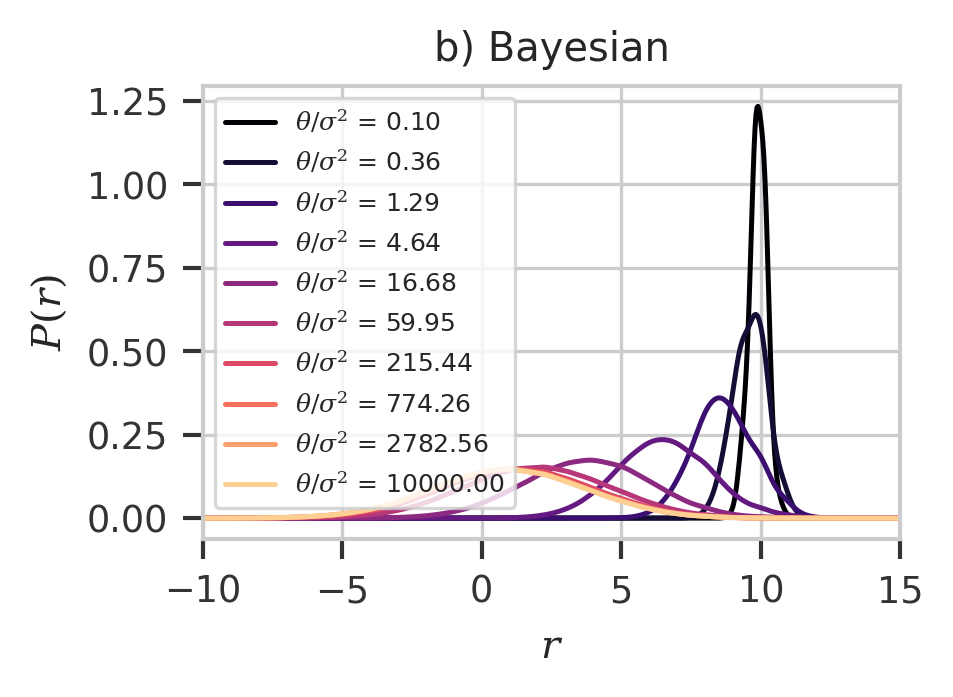

In [13]:
# https://pubmed.ncbi.nlm.nih.gov/26723635/
plt.figure(figsize=(3,2), dpi=300)
x = np.linspace(-10, 25, 1000)
cmap = plt.get_cmap('magma')
prior_theta = 10**np.linspace(-1, 4, 10)
bpdf = np.exp(-(y - 10)**2 / (2 * prior_theta[:, np.newaxis]))
bpdf /= np.sum(bpdf, axis=1)[:, np.newaxis]
for i,p in enumerate(prior_theta):
    ppdf = scipy.stats.gaussian_kde(np.squeeze(y), weights=bpdf[i])    
    plt.plot(x, ppdf.pdf(x), color=cmap(i / len(prior_theta)), label=f'$\\theta/\\sigma$ = {p:.2f}')
plt.legend(fontsize=6)
plt.xlim(-10, 15)
plt.xlabel(r'$r$')
plt.ylabel(r'$P(r)$')
plt.title('b) Bayesian')
plt.savefig('bayes.svg')
plt.show()

## Effects of Observable

In [11]:
bayesian_results = []
#scipy.stats.wasserstein_distance(y, y, u_weights=np.ones_like(y) / len(y), v_weights=bpdf[i])])
x2 = np.linspace(-20, 20, 10000)
for i in range(len(prior)):
    ppdf = scipy.stats.gaussian_kde(np.squeeze(y), weights=bpdf[i])    
    bayesian_results.append([np.sum(ppdf.pdf(x) * x * (x[1] - x[0])),  
          -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))])
    print(i, bayesian_results[-1])

<ipython-input-11-d50bf3f8a187>:7: RuntimeWarning: divide by zero encountered in log
  -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))])
<ipython-input-11-d50bf3f8a187>:7: RuntimeWarning: invalid value encountered in multiply
  -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))])


0 [9.959884288256418, -0.04617580612292206]
1 [9.828251785807408, 0.6194394063365228]
2 [9.313669312575607, 1.2498503528700726]
3 [7.845671350762425, 1.7409800163105658]
4 [5.244404906075395, 2.1075488109635367]
5 [2.7949338286073364, 2.3193305228519563]
6 [1.5814480114826293, 2.395870134177332]
7 [1.1685552143857127, 2.419159254761848]
8 [1.046470811599532, 2.425821466057383]
9 [1.0119065991873049, 2.4276894832011875]


In [12]:
me_results = []
for i in range(-5, 10):
    r = maxent.Restraint(lambda x: x, i, maxent.EmptyPrior())
    m = maxent.MaxentModel([r])
    m.compile(tf.keras.optimizers.Adam(0.001), 'mean_squared_error')
    m.fit(y, epochs=4, batch_size=256, verbose=0)    
    #d = scipy.stats.wasserstein_distance(y, y, u_weights=m.traj_weights)
    ppdf = scipy.stats.gaussian_kde(y, weights=m.traj_weights)    
    d=  -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))
    me_results.append([i, d])
    print(np.sum(y * m.traj_weights), d)

-4.760423 2.306920594057825
-3.810947 2.3694516345502064
-2.8259637 2.4038350684322842
-1.900872 2.418447778065223
-0.9553167 2.424371353336168
0.027614225 2.426882573288194


<ipython-input-12-f06cc5eeaadb>:9: RuntimeWarning: divide by zero encountered in log
  d=  -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))
<ipython-input-12-f06cc5eeaadb>:9: RuntimeWarning: invalid value encountered in multiply
  d=  -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))


1.0098245 2.428427370995926
1.9941295 2.4295492554423133
2.9686315 2.430669696944458
3.8970127 2.4338146111301757
4.834799 2.443655280573724
5.8534675 2.4694963629991014
6.8461313 2.5148259771294734
7.641946 2.5621808312962413
8.217657 2.5977537793969123


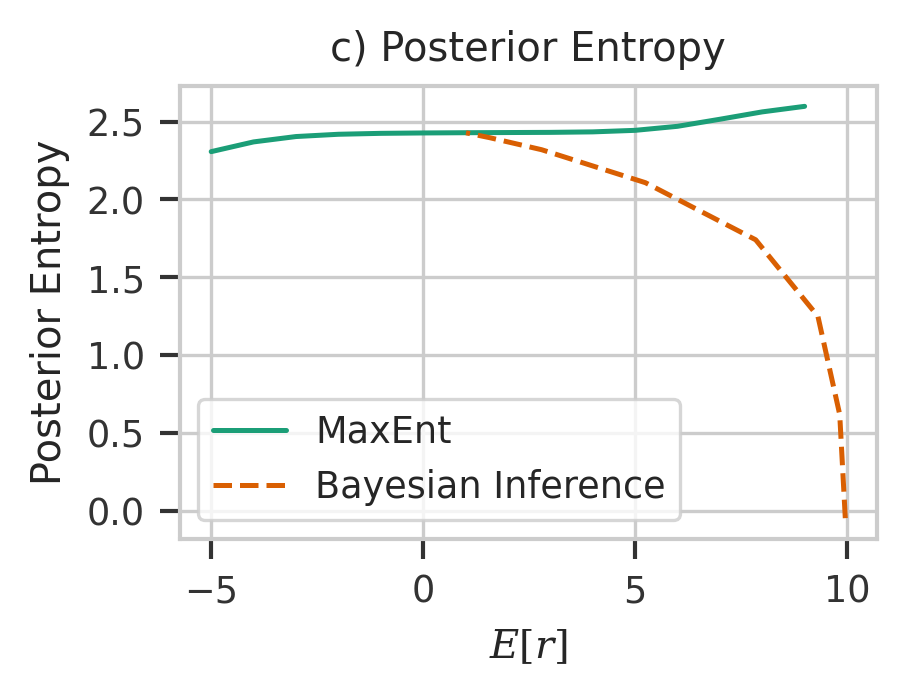

In [13]:
plt.figure(figsize=(3,2), dpi=300)
me_result = np.array(me_results)
bayesian_results = np.array(bayesian_results)
plt.plot(me_result[:, 0], me_result[:,1], label='MaxEnt', color=colors[0])
plt.plot(bayesian_results[:,0], bayesian_results[:,1], linestyle='--', label='Bayesian Inference', color=colors[1])
plt.ylabel('Posterior Entropy')
plt.xlabel('$E[r]$')
plt.legend()
plt.title('c) Posterior Entropy')
plt.savefig('post.svg')
plt.show()


In [14]:
bayesian_results[:]

array([[ 9.95988429, -0.04617581],
       [ 9.82825179,  0.61943941],
       [ 9.31366931,  1.24985035],
       [ 7.84567135,  1.74098002],
       [ 5.24440491,  2.10754881],
       [ 2.79493383,  2.31933052],
       [ 1.58144801,  2.39587013],
       [ 1.16855521,  2.41915925],
       [ 1.04647081,  2.42582147],
       [ 1.0119066 ,  2.42768948]])